# From detected synch cues, produce restamped raw Equivital and fixed intervals on march 4th, Monday
Note this interval didn't include any specific experiment intervals, so we are just generating the realigned files incase they end up being useful for different analyses later.

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [3]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

In [10]:
cues_df.loc[cues_df['Cue1_s'].notna(),:]

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
SUBJECT ID,,,,,,,,,,,,,,,,,,
VN101,2024-03-04 07:56:25.407331250,-1.644531,0.489273,2024-03-04 14:25:43.633925000,0.109375,0.682468,0 days 06:29:18.226593750,23358.226594,3420415,-3.210606,-0.494755,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN102,2024-03-04 07:56:25.383893750,-1.621094,0.495585,2024-03-04 14:25:44.051893750,-0.308594,0.707907,0 days 06:29:18.668000,23358.668000,3420426,-2.769200,-0.426734,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN103,2024-03-04 07:56:25.262800000,-1.500000,0.665827,2024-03-04 14:25:44.329237500,-0.585938,0.848838,0 days 06:29:19.066437500,23359.066438,3420427,-2.370762,-0.365335,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN106,2024-03-04 07:56:25.985456250,-2.222656,0.687329,2024-03-04 14:25:45.981581250,-2.238281,0.847009,0 days 06:29:19.996125,23359.996125,5022002,-1.441075,-0.222070,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN105,2024-03-04 07:56:26.739362500,-2.976562,0.472968,2024-03-04 14:25:45.348768750,-1.605469,0.774134,0 days 06:29:18.609406250,23358.609406,3420755,-2.827794,-0.435763,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC702,2024-03-04 07:56:26.055768750,-1.292969,0.555586,2024-03-04 14:25:47.071425000,-2.328125,0.749781,0 days 06:29:21.015656250,23361.015656,5022240,-0.421544,-0.064960,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC703,2024-03-04 07:56:25.282331250,-1.519531,0.576534,2024-03-04 14:25:45.321425000,-1.578125,0.802204,0 days 06:29:20.039093750,23360.039094,5022241,-1.398106,-0.215448,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC704,2024-03-04 07:56:25.790143750,-2.027344,0.575410,2024-03-04 14:25:45.973768750,-2.230469,0.802896,0 days 06:29:20.183625,23360.183625,5022244,-1.253575,-0.193176,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200


In [12]:
cues_df = pd.read_csv('./outfiles/'+'Cue_ACC_dev_align_20240304.csv',index_col = 0)
cues_df = cues_df.loc[cues_df['Cue1_s'].notna(),:].copy()
for c in cues_df.columns:
    if c.endswith('dt') or c.endswith('dTime'):
        if c.startswith('dur'):
            cues_df[c] = pd.to_timedelta(cues_df[c])
        else:
            cues_df[c] = pd.to_datetime(cues_df[c])
cues_df

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
SUBJECT ID,,,,,,,,,,,,,,,,,,
VN101,2024-03-04 07:56:25.407331250,-1.644531,0.489273,2024-03-04 14:25:43.633925000,0.109375,0.682468,0 days 06:29:18.226593750,23358.226594,3420415,-3.210606,-0.494755,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN102,2024-03-04 07:56:25.383893750,-1.621094,0.495585,2024-03-04 14:25:44.051893750,-0.308594,0.707907,0 days 06:29:18.668000,23358.668000,3420426,-2.769200,-0.426734,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN103,2024-03-04 07:56:25.262800000,-1.500000,0.665827,2024-03-04 14:25:44.329237500,-0.585938,0.848838,0 days 06:29:19.066437500,23359.066438,3420427,-2.370762,-0.365335,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN106,2024-03-04 07:56:25.985456250,-2.222656,0.687329,2024-03-04 14:25:45.981581250,-2.238281,0.847009,0 days 06:29:19.996125,23359.996125,5022002,-1.441075,-0.222070,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN105,2024-03-04 07:56:26.739362500,-2.976562,0.472968,2024-03-04 14:25:45.348768750,-1.605469,0.774134,0 days 06:29:18.609406250,23358.609406,3420755,-2.827794,-0.435763,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC702,2024-03-04 07:56:26.055768750,-1.292969,0.555586,2024-03-04 14:25:47.071425000,-2.328125,0.749781,0 days 06:29:21.015656250,23361.015656,5022240,-0.421544,-0.064960,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC703,2024-03-04 07:56:25.282331250,-1.519531,0.576534,2024-03-04 14:25:45.321425000,-1.578125,0.802204,0 days 06:29:20.039093750,23360.039094,5022241,-1.398106,-0.215448,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC704,2024-03-04 07:56:25.790143750,-2.027344,0.575410,2024-03-04 14:25:45.973768750,-2.230469,0.802896,0 days 06:29:20.183625,23360.183625,5022244,-1.253575,-0.193176,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200


In [45]:
# {'cue1_20240309': Timestamp('2024-03-09 12:29:20.294512472'),
#  'cue2_20240309': Timestamp('2024-03-09 16:43:11.326464853')}
df_timings = pd.DataFrame(columns=['Event','Event_Type','SS_sTime','SS_dTime'])
Event_data = {'Event':'','Event_Type':'','SS_sTime':0,'SS_dTime':pd.to_timedelta('nan')}
# start of the synch spider audio 
sync_start = (pd.to_datetime('2024-03-04 07:56:23.762800')-pd.to_timedelta(285.762812,unit='s')).tz_localize(None)

In [46]:
# 19059.7765
i=0
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_Start'
event_dets['SS_sTime']= 285.762812 # actually the alignment with synch spider recording
event_dets['SS_dTime']= pd.to_datetime('2024-03-04 07:56:23.762800').tz_localize(None)
df_timings.loc[i,:]=event_dets

# The second sync cue is missing from the audio, it cuts at 23624.630 s
i=1 # estimated after median drift correction. Before that, avg sync2 cue time was 23359.8664
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_End' 
event_dets['SS_sTime']= 23361.7018 + 285.762812
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets


df_timings

,Event,Event_Type,SS_sTime,SS_dTime
0,Sync,Sync_Start,285.762812,2024-03-04 07:56:23.762800
1,Sync,Sync_End,23647.464612,2024-03-04 14:25:45.464600


In [47]:
# the problem recording is 'VN104'
# 'VN104' doesn't have an end cue, so need to use median drift
['VN104']
df_drifts=pd.read_csv('./outfiles/'+'dev_drift.csv', index_col=0)
df_drifts.loc['VN104','median_C']

1.0001425887879094

In [48]:
df_shifts=pd.read_csv('./outfiles/Cue_ACC_dev_align_20240304.csv', index_col=0)
df_shifts = df_shifts.loc[df_shifts['Cue1_s'].notna(),:].copy()

df_shifts['Cue1_devdTime'] = pd.to_datetime(df_shifts['Cue1_devdTime']).dt.tz_localize(None)
df_shifts['Cue2_devdTime'] = pd.to_datetime(df_shifts['Cue2_devdTime']).dt.tz_localize(None)
df_shifts['dur_dt'] = pd.to_timedelta(df_shifts['dur_dt'])
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
SUBJECT ID,,,,,,,,,,,,,,,,,,
VN101,2024-03-04 07:56:25.407331250,-1.644531,0.489273,2024-03-04 14:25:43.633925000,0.109375,0.682468,0 days 06:29:18.226593750,23358.226594,3420415,-3.210606,-0.494755,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN102,2024-03-04 07:56:25.383893750,-1.621094,0.495585,2024-03-04 14:25:44.051893750,-0.308594,0.707907,0 days 06:29:18.668000,23358.668000,3420426,-2.769200,-0.426734,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN103,2024-03-04 07:56:25.262800000,-1.500000,0.665827,2024-03-04 14:25:44.329237500,-0.585938,0.848838,0 days 06:29:19.066437500,23359.066438,3420427,-2.370762,-0.365335,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN106,2024-03-04 07:56:25.985456250,-2.222656,0.687329,2024-03-04 14:25:45.981581250,-2.238281,0.847009,0 days 06:29:19.996125,23359.996125,5022002,-1.441075,-0.222070,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN105,2024-03-04 07:56:26.739362500,-2.976562,0.472968,2024-03-04 14:25:45.348768750,-1.605469,0.774134,0 days 06:29:18.609406250,23358.609406,3420755,-2.827794,-0.435763,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC702,2024-03-04 07:56:26.055768750,-1.292969,0.555586,2024-03-04 14:25:47.071425000,-2.328125,0.749781,0 days 06:29:21.015656250,23361.015656,5022240,-0.421544,-0.064960,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC703,2024-03-04 07:56:25.282331250,-1.519531,0.576534,2024-03-04 14:25:45.321425000,-1.578125,0.802204,0 days 06:29:20.039093750,23360.039094,5022241,-1.398106,-0.215448,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC704,2024-03-04 07:56:25.790143750,-2.027344,0.575410,2024-03-04 14:25:45.973768750,-2.230469,0.802896,0 days 06:29:20.183625,23360.183625,5022244,-1.253575,-0.193176,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200


In [49]:
data_dir='/Volumes/SeagateHub/BiC2024/20240304/Equivital/Extracted/'

sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
# this set of files wasn't cleaned of the little files generated by accident
df_datafiles = df_datafiles.loc[df_datafiles['FileSize']>130000,:].copy() 
df_datafiles.set_index('DevName',inplace=True)
df_datafiles = df_datafiles.loc[df_shifts.index].copy()
df_datafiles

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,FullLoc,DATAloc,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
SUBJECT ID,,,,,,,,,,,,,,,,,,,,,
VN101,DATA,3420415,240304,101,DATA-VN101-3420415-24030400_0.CSV,csv,138727,2024-03-04 07:32:58+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN101],3420415.0,VN101,53.0,0.0,100.0,1.0,1.0,Stationary,Side
VN102,DATA,3420426,240304,101,DATA-VN102-3420426-24030400_0.CSV,csv,136675,2024-03-04 07:32:59+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN102],3420426.0,VN102,53.0,0.0,100.0,1.0,1.0,Stationary,Side
VN103,DATA,3420427,240304,101,DATA-VN103-3420427-24030400_0.CSV,csv,136681,2024-03-04 07:33:08+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN103],3420427.0,VN103,53.0,0.0,100.0,1.0,1.0,Stationary,Side
VN106,DATA,5022002,240304,1,DATA-VN106-5022002-24030401.CSV,csv,136269,2024-03-04 07:33:11+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN106],5022002.0,VN106,53.0,0.0,100.0,1.0,1.0,Stationary,Side
VN105,DATA,3420755,240304,101,DATA-VN105-3420755-24030400_0.CSV,csv,137950,2024-03-04 07:33:13+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN105],3420755.0,VN105,53.0,0.0,100.0,1.0,1.0,Stationary,Side
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC702,DATA,5022240,240304,101,DATA-PC702-5022240-24030400_0.CSV,csv,137997,2024-03-04 07:52:10+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[PC702],5022240.0,PC702,53.0,0.0,98.0,0.0,0.0,Stationary,Upright
PC703,DATA,5022241,240304,101,DATA-PC703-5022241-24030400_0.CSV,csv,144525,2024-03-04 07:52:10+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[PC703],5022241.0,PC703,53.0,0.0,100.0,1.0,1.0,Stationary,Side
PC704,DATA,5022244,240304,101,DATA-PC704-5022244-24030400_0.CSV,csv,144426,2024-03-04 07:52:12+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[PC704],5022244.0,PC704,53.0,0.0,100.0,1.0,1.0,Stationary,Side


# Test Realign and cut
test alignment of sync cues 1 and 2 with clock corrections applied to two SEM measurements

In [29]:
sync1_s = 0
sync1_dt = df_timings.loc[0,'SS_dTime']
sync2_s = df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime']
sync2_dt = df_timings.loc[1,'SS_dTime']

In [50]:
pid = 'VN109'
dets = df_datafiles.loc[pid,:]
dets

Signal                                                            DATA
ID                                                             5022010
Date                                                            240304
Session                                                            101
FileName                             DATA-VN109-5022010-24030400_0.CSV
FileType                                                           csv
FileSize                                                        136337
RecStart                                     2024-03-04 07:37:57+00:00
FullLoc              /Volumes/SeagateHub/BiC2024/20240304/Equivital...
DATAloc              /Volumes/SeagateHub/BiC2024/20240304/Equivital...
ACCloc               /Volumes/SeagateHub/BiC2024/20240304/Equivital...
RESPloc              /Volumes/SeagateHub/BiC2024/20240304/Equivital...
RRloc                /Volumes/SeagateHub/BiC2024/20240304/Equivital...
ECGloc               /Volumes/SeagateHub/BiC2024/20240304/Equivital...
RecEnd

In [51]:
df_shifts.loc[pid,:]

Cue1_devdTime                          2024-03-04 07:56:25.708112500
Cue1_s                                                     -1.945312
Cue1_r                                                      0.692887
Cue2_devdTime                          2024-03-04 14:25:45.485487500
Cue2_s                                                     -1.742188
Cue2_r                                                      0.716406
dur_dt                                        0 days 06:29:19.777375
dur_s                                                   23359.777375
devID                                                        5022010
drift_s                                                    -1.659825
drift_rate_sphr                                            -0.255779
ACCFile            /Volumes/Seagatehub/BiC2024/20240304/Equivital...
Cue1_file                           ./outfiles/cue1_acc_20240304.csv
Cue1_name                                              cue1_20240304
Cue1_dt                           

In [32]:
df_datafiles.loc[pid,'ACCloc']

'/Volumes/SeagateHub/BiC2024/20240304/Equivital/Extracted/VN109/FASTACC-VN109-5022010-24030400_0.CSV'

In [33]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']).dt.tz_localize(None)
ACC[['X','Y','Z']] = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))

drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
print(drift_C)
ACC['rTime_s'] =np.round((ACC['dev_dTime']-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,3)+df_timings.loc[0,'SS_sTime']
#  df_timings.loc[0,'SS_sTime'] + 
ACC['rTime_dt'] = pd.to_timedelta(ACC['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
ACC.iloc[:5,:]


1.0000823819923068


,dev_dTime,X,Y,Z,signal,rTime_s,rTime_dt
0,2024-03-04 07:37:29.007,0,0,0,0.0,-1136.795,2024-03-04 07:37:26.967800
1,2024-03-04 07:37:29.011,0,0,0,0.0,-1136.791,2024-03-04 07:37:26.971800
2,2024-03-04 07:37:29.015,0,0,0,0.0,-1136.787,2024-03-04 07:37:26.975800
3,2024-03-04 07:37:29.019,0,0,0,0.0,-1136.783,2024-03-04 07:37:26.979800
4,2024-03-04 07:37:29.023,0,0,0,0.0,-1136.779,2024-03-04 07:37:26.983800


In [34]:
ACC1 = ACC.copy()

In [52]:
pid = 'VN201'

V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']).dt.tz_localize(None)
ACC[['X','Y','Z']] = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))

drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
print(drift_C)
ACC['rTime_s'] =np.round((ACC['dev_dTime']-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,3)+df_timings.loc[0,'SS_sTime']
#  df_timings.loc[0,'SS_sTime'] + 
ACC['rTime_dt'] = pd.to_timedelta(ACC['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
ACC.iloc[:5,:]


1.0000681672321103


,dev_dTime,X,Y,Z,signal,rTime_s,rTime_dt
0,2024-03-04 07:37:34.007,0,0,0,0.0,-846.453188,2024-03-04 07:37:31.546800
1,2024-03-04 07:37:34.011,0,0,0,0.0,-846.449188,2024-03-04 07:37:31.550800
2,2024-03-04 07:37:34.015,0,0,0,0.0,-846.445188,2024-03-04 07:37:31.554800
3,2024-03-04 07:37:34.019,0,0,0,0.0,-846.441188,2024-03-04 07:37:31.558800
4,2024-03-04 07:37:34.023,0,0,0,0.0,-846.437188,2024-03-04 07:37:31.562800


Test out put: are these two signals aligned in rTime_s, in rTime_dt?

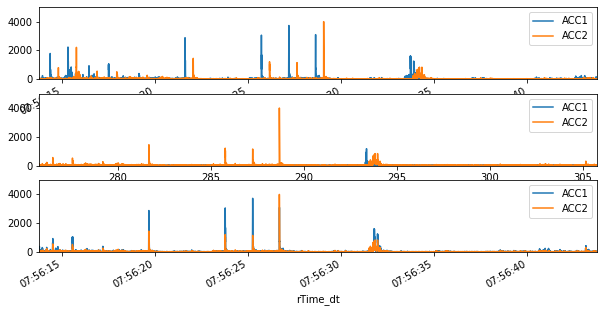

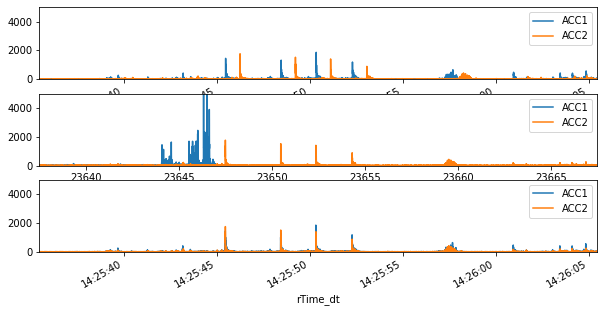

In [53]:
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[0,'SS_sTime']-10,df_timings.loc[0,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[0,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[0,'SS_dTime']+pd.to_timedelta(20,unit='s')])
    axes[i].set_ylim([0,5000])
plt.show()
    
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[1,'SS_sTime']-10,df_timings.loc[1,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[1,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[1,'SS_dTime']+pd.to_timedelta(20,unit='s')])
    axes[i].set_ylim([0,5000])
plt.show()
     

The correction looks about right, so we proceed to apply it to tall the measurements

# Output full and for each event


In [42]:
sync1_s = 0
sync1_dt = df_timings.loc[0,'SS_dTime']
sync2_s = df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime']
sync2_dt = df_timings.loc[1,'SS_dTime']

In [54]:
df_datafiles

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,FullLoc,DATAloc,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
SUBJECT ID,,,,,,,,,,,,,,,,,,,,,
VN101,DATA,3420415,240304,101,DATA-VN101-3420415-24030400_0.CSV,csv,138727,2024-03-04 07:32:58+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN101],3420415.0,VN101,53.0,0.0,100.0,1.0,1.0,Stationary,Side
VN102,DATA,3420426,240304,101,DATA-VN102-3420426-24030400_0.CSV,csv,136675,2024-03-04 07:32:59+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN102],3420426.0,VN102,53.0,0.0,100.0,1.0,1.0,Stationary,Side
VN103,DATA,3420427,240304,101,DATA-VN103-3420427-24030400_0.CSV,csv,136681,2024-03-04 07:33:08+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN103],3420427.0,VN103,53.0,0.0,100.0,1.0,1.0,Stationary,Side
VN106,DATA,5022002,240304,1,DATA-VN106-5022002-24030401.CSV,csv,136269,2024-03-04 07:33:11+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN106],5022002.0,VN106,53.0,0.0,100.0,1.0,1.0,Stationary,Side
VN105,DATA,3420755,240304,101,DATA-VN105-3420755-24030400_0.CSV,csv,137950,2024-03-04 07:33:13+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[VN105],3420755.0,VN105,53.0,0.0,100.0,1.0,1.0,Stationary,Side
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC702,DATA,5022240,240304,101,DATA-PC702-5022240-24030400_0.CSV,csv,137997,2024-03-04 07:52:10+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[PC702],5022240.0,PC702,53.0,0.0,98.0,0.0,0.0,Stationary,Upright
PC703,DATA,5022241,240304,101,DATA-PC703-5022241-24030400_0.CSV,csv,144525,2024-03-04 07:52:10+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[PC703],5022241.0,PC703,53.0,0.0,100.0,1.0,1.0,Stationary,Side
PC704,DATA,5022244,240304,101,DATA-PC704-5022244-24030400_0.CSV,csv,144426,2024-03-04 07:52:12+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,[PC704],5022244.0,PC704,53.0,0.0,100.0,1.0,1.0,Stationary,Side


In [55]:
CUTLOGS = pd.concat([df_datafiles,df_shifts],axis=1)#,CUTLOGS
CUTS= pd.Series()
CUTS[pid] = []

newdata_dir='/Volumes/SeagateHub/BiC2024_Synced/Equivital/'

sig_map = {'DATAloc':'EQDATA','ACCloc':'EQBACC','RESPloc':'EQRESP','RRloc':'EQCIBI','ECGloc':'EQ2ECG'}
cut_ind = 0
toc = time.time()
rec_day = '20240304'
buff = pd.to_timedelta(15,unit='s') # 2 minute buffer on cutes for concert and stuff pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s')
segmentid = 'FULL'

for pid in CUTLOGS.index: # had to restart after VN212 as that is missing 
    tic = time.time()
    outfiles = []
    tic = time.time()
    if pid == 'VN104': # use estimate
        drift_C = df_drifts.loc[pid,'median_C']
    else: 
        drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
    eqfiles = df_datafiles.loc[pid,['DATAloc','ACCloc','RESPloc','RRloc','ECGloc']]
    for f in eqfiles.index:
        SignalID = sig_map[f]
        V = pd.read_csv(eqfiles[f],skipinitialspace=True)
        dt_col = V.columns[0] # assume first column is time, specifically datetime
        sig_col = V.columns[1:]
        V[dt_col]=pd.to_datetime(V[dt_col]).dt.tz_localize(None) # .dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')
        V['rTime_s'] =np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        V['rTime_dt'] = pd.to_timedelta(V['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig = pd.DataFrame()
        RecTimeSig['rec_sTime'] = np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['rec_sTime']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig['dev_dTime'] = V[dt_col]
        RecTimeSig.loc[:,sig_col] = V[sig_col]
        
        seg_filename = '_'.join([pid,rec_day,'FULL',SignalID+'.csv'])
        new_col_order=['rec_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        RecTimeSig[new_col_order].to_csv(newdata_dir + 'FullDay/'+ rec_day+ '/'+ seg_filename, index = False)

        new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        
        print(' '.join([pid,SignalID ,str(np.round(time.time() - tic,3)),str(np.round(time.time() - toc,3))]))
    CUTS[pid] = outfiles

# CUTS= pd.Series()
# CUTS[pid] = []
CUTLOGS['Output_files']=CUTS
CUTLOGS.to_csv('./outfiles/'+rec_day+'EQIVITALS_CUTLOGS.csv')
# CUTLOGS['Scaling_C'].hist()
# plt.show()
CUTLOGS

VN101 EQDATA 1.391 1.392
VN101 EQBACC 65.547 65.548
VN101 EQRESP 71.582 71.583
VN101 EQCIBI 71.631 71.632
VN101 EQ2ECG 141.34 141.341
VN102 EQDATA 0.135 141.477
VN102 EQBACC 62.154 203.495
VN102 EQRESP 68.636 209.978
VN102 EQCIBI 68.712 210.054
VN102 EQ2ECG 136.177 277.519
VN103 EQDATA 0.119 277.639
VN103 EQBACC 67.337 344.857
VN103 EQRESP 73.321 350.841
VN103 EQCIBI 73.344 350.864
VN103 EQ2ECG 146.909 424.429
VN106 EQDATA 0.149 424.58
VN106 EQBACC 65.615 490.046
VN106 EQRESP 71.642 496.073
VN106 EQCIBI 71.676 496.107
VN106 EQ2ECG 139.564 563.995
VN105 EQDATA 0.16 564.156
VN105 EQBACC 63.957 627.953
VN105 EQRESP 70.01 634.006
VN105 EQCIBI 70.117 634.113
VN105 EQ2ECG 136.593 700.589
VN107 EQDATA 0.196 700.786
VN107 EQBACC 64.636 765.226
VN107 EQRESP 70.503 771.093
VN107 EQCIBI 70.534 771.123
VN107 EQ2ECG 140.426 841.016
VN108 EQDATA 0.118 841.135
VN108 EQBACC 61.559 902.576
VN108 EQRESP 67.351 908.368
VN108 EQCIBI 67.389 908.406
VN108 EQ2ECG 136.291 977.308
VN204 EQDATA 0.159 977.468
VN

PC701 EQBACC 61.03 7369.492
PC701 EQRESP 66.957 7375.419
PC701 EQCIBI 67.019 7375.48
PC701 EQ2ECG 132.979 7441.441
PC702 EQDATA 0.125 7441.566
PC702 EQBACC 56.735 7498.176
PC702 EQRESP 62.263 7503.705
PC702 EQCIBI 62.632 7504.073
PC702 EQ2ECG 124.111 7565.552
PC703 EQDATA 0.12 7565.673
PC703 EQBACC 61.501 7627.054
PC703 EQRESP 67.421 7632.974
PC703 EQCIBI 67.467 7633.02
PC703 EQ2ECG 134.216 7699.77
PC704 EQDATA 0.157 7699.928
PC704 EQBACC 60.518 7760.288
PC704 EQRESP 66.605 7766.375
PC704 EQCIBI 66.639 7766.41
PC704 EQ2ECG 132.489 7832.26
PC705 EQDATA 0.135 7832.396
PC705 EQBACC 60.682 7892.942
PC705 EQRESP 66.59 7898.851
PC705 EQCIBI 66.79 7899.051
PC705 EQ2ECG 133.975 7966.236
PC709 EQDATA 0.154 7966.391
PC709 EQBACC 57.982 8024.219
PC709 EQRESP 63.577 8029.814
PC709 EQCIBI 63.979 8030.216
PC709 EQ2ECG 126.685 8092.921


,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,FullLoc,DATAloc,...,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt,Output_files
SUBJECT ID,,,,,,,,,,,,,,,,,,,,,
VN101,DATA,3420415,240304,101,DATA-VN101-3420415-24030400_0.CSV,csv,138727,2024-03-04 07:32:58+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,-3.210606,-0.494755,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200,[]
VN102,DATA,3420426,240304,101,DATA-VN102-3420426-24030400_0.CSV,csv,136675,2024-03-04 07:32:59+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,-2.769200,-0.426734,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200,[]
VN103,DATA,3420427,240304,101,DATA-VN103-3420427-24030400_0.CSV,csv,136681,2024-03-04 07:33:08+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,-2.370762,-0.365335,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200,[]
VN106,DATA,5022002,240304,1,DATA-VN106-5022002-24030401.CSV,csv,136269,2024-03-04 07:33:11+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,-1.441075,-0.222070,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200,[]
VN105,DATA,3420755,240304,101,DATA-VN105-3420755-24030400_0.CSV,csv,137950,2024-03-04 07:33:13+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,-2.827794,-0.435763,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC702,DATA,5022240,240304,101,DATA-PC702-5022240-24030400_0.CSV,csv,137997,2024-03-04 07:52:10+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,-0.421544,-0.064960,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200,[]
PC703,DATA,5022241,240304,101,DATA-PC703-5022241-24030400_0.CSV,csv,144525,2024-03-04 07:52:10+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,-1.398106,-0.215448,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200,[]
PC704,DATA,5022244,240304,101,DATA-PC704-5022244-24030400_0.CSV,csv,144426,2024-03-04 07:52:12+00:00,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,/Volumes/SeagateHub/BiC2024/20240304/Equivital...,...,-1.253575,-0.193176,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200,[]


In [64]:
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             3420426
Date                                                            240308
Session                                                              0
FileName                               DATA-AU802-3420426-24030800.CSV
FileType                                                           csv
FileSize                                                        156433
RecStart                                     2024-03-08 06:34:21+00:00
RecEnd                                       2024-03-08 14:25:51+00:00
Duration                                                       28290.0
BatteryStart                                                      4123
BatteryEnd                                                        3953
BatteryChange(mV)                                                 -170
FullLoc              /Volumes/SeagateHub/BiC2024/20240308/Equivital...
DATAlo

In [47]:
eqfiles

DATAloc    /Volumes/SeagateHub/BiC2024/20240308/Equivital...
ACCloc     /Volumes/SeagateHub/BiC2024/20240308/Equivital...
RESPloc    /Volumes/SeagateHub/BiC2024/20240308/Equivital...
RRloc      /Volumes/SeagateHub/BiC2024/20240308/Equivital...
ECGloc     /Volumes/SeagateHub/BiC2024/20240308/Equivital...
Name: VN211, dtype: object

In [ ]:
# 4099.328 for all segments